In [1]:
import numpy as np
import time
import math
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

In [2]:
def oprod(T):
    out=T[0]
    for i in range(1,len(T)):
        out=np.multiply.outer(out,T[i])
    return out
def ID(N,d):
    out=np.zeros((N,)*d,dtype=int)
    for i in range(N):
        out[(i,)*A]=1
    return out
def readmat(info,vals=(lambda c:-1 if c=='n' else ord(c)-ord('0'))):
    return np.array(list(map(
        lambda rowstr:list(map(vals,list(rowstr))),
        info.split('.'))))
def mmT(N):
    T=np.zeros((N,)*6,dtype=int)
    for i in range(N):
        for j in range(N):
            for k in range(N):
                T[i][j][j][k][k][i]=1
    return T
def compress(T):
    S=T.shape
    assert len(S)%2==0, 'odd-dimensional tensor'
    nS=[]
    for i in range(0,len(S),2):
        nS.append(S[i]*S[i+1])
    return T.reshape(tuple(nS))
def sumdecomp(decomp):
    return sum(map(oprod,decomp))
def plotT(ax,T,cmapname='bwr',s=100,**kwargs):
    data=np.array(np.where(T!=0))
    vals=np.array(list(map(lambda pt:T[tuple(pt)],np.transpose(data))))
    ax.scatter(*data,c=list(map(plt.get_cmap(cmapname),256*vals/max(abs(max(vals)),abs(min(vals))))),**kwargs)

In [142]:
class SparseTensor: #data structure for storing sparse tensors
    def __init__(self,shape,pts={}):
        assert isinstance(shape,tuple), 'shape is not a tuple'
        self.shape=shape
        for pt in pts:
            assert len(pt)==len(self.shape), 'incorrect dimension # for pt'
            for d in range(len(self.shape)):
                assert 0<=pt[d] and pt[d]<self.shape[d], 'pt '+str(pt)+'out of bounds '+str(self.shape)
                assert not(isinstance(pt[d],float)), 'non-integer index: '+str(pt)+' (type='+str(type(pt[d]))+')'
        self.pts=dict(pts)
        #^^^ simply saying self.pts causes a strange bug where all-0 matrices are incorrectly initialized
    def toarr(self):
        out=np.zeros(self.shape)
        for k in self.pts:
            out[k]=self.pts[k]
        return out
    def __str__(self):
        return str(self.shape)+': '+str(self.pts)
    def __neg__(self):
        return self*(-1)
    def __add__(self,o):
        if isinstance(o,SparseTensor): #element-wise sum
            assert self.shape==o.shape, 'adding two SpraseTensors with different shapes'
            out=SparseTensor(self.shape)
            pts=set((*list(self.pts.keys()),*list(o.pts.keys())))
            for k in pts:
                v=(self.pts[k] if k in self.pts else 0)+(o.pts[k] if k in o.pts else 0)
                if v!=0:
                    out.pts[k]=v
            return out
        else:
            return SparseTensor(self.shape,{k:o+self.pts[k] for k in self.pts})
    def __radd__(self,o):
        return self+o
    def __mul__(self,o):
        if isinstance(o,SparseTensor): #outer product
            out=SparseTensor(self.shape+o.shape)
            for k in self.pts:
                for m in o.pts:
                    v=self.pts[k]*o.pts[m]
                    if v!=0:
                        out.pts[k+m]=v
            return out
        else:
            return SparseTensor(self.shape,{k:o*self.pts[k] for k in self.pts})
        raise 'multiplying a SparseTensor by something other than a scalar or SparseTensor'
    def __rmul__(self,o):
        return self*o

In [152]:
#simplified version of Pan's initial trilinear aggregation technique
N=6
E=lambda i,j:SparseTensor((2*N,)*2,{(i,j):1})
S=set()
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i<=j and j<k) or (k<j and j<=i):
                S.add((i,j,k))
Sij,Sjk,Ski=set([(i,j) for i,j,k in S]),set([(j,k) for i,j,k in S]),set([(k,i) for i,j,k in S])
assert Sjk==Ski, 'sets Sjk and Ski are not equal'
def Pan_decomp(C,I):
    X=lambda s,t,r,c:C[s][t]*E(r+I[s][(s+t)%3]*N,c+I[s][(s+t+1)%3]*N)
    return [
        *[(X(0,0,i,j)+X(1,0,j,k)+X(2,0,k,i),X(0,1,j,k)+X(1,1,k,i)+X(2,1,i,j),X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) for i,j,k in S],

        *[(-X(0,0,i,j),X(2,1,i,j),sum([X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k) if (i,j,k) in S else 0 for k in range(N)])) for i,j in Sij],
        *[(-X(0,0,i,j),sum([(X(0,1,j,k)+X(1,1,k,i)) if (i,j,k) in S else 0 for k in range(N)]),X(1,2,i,j)) for i,j in Sij],
        *[(-sum([(X(1,0,j,k)+X(2,0,k,i)) if (i,j,k) in S else 0 for k in range(N)]),X(2,1,i,j),X(1,2,i,j)) for i,j in Sij],

        *[(-X(1,0,j,k),X(0,1,j,k),sum([(X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) if (i,j,k) in S else 0 for i in range(N)])) for j,k in Sjk],
        *[(-X(1,0,j,k),sum([(X(1,1,k,i)+X(2,1,i,j)) if (i,j,k) in S else 0 for i in range(N)]),X(2,2,j,k)) for j,k in Sjk],
        *[(-sum([(X(0,0,i,j)+X(2,0,k,i)) if (i,j,k) in S else 0 for i in range(N)]),X(0,1,j,k),X(2,2,j,k)) for j,k in Sjk],

        *[(-X(2,0,k,i),X(1,1,k,i),sum([(X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) if (i,j,k) in S else 0 for j in range(N)])) for k,i in Ski],
        *[(-X(2,0,k,i),sum([(X(0,1,j,k)+X(2,1,i,j)) if (i,j,k) in S else 0 for j in range(N)]),X(0,2,k,i)) for k,i in Ski],
        *[(-sum([(X(0,0,i,j)+X(1,0,j,k)) if (i,j,k) in S else 0 for j in range(N)]),X(1,1,k,i),X(0,2,k,i)) for k,i in Ski],
    ]
coeffss=[]
for i in range(4):
    tmp=np.ones((3,3))
    if i>0:
        tmp[i-1][0]=tmp[i-1][2]=-1
    coeffss.append(tmp)
sigs=[np.zeros((3,3),dtype=int),[[0,0,1],[0,1,0],[1,0,0]],[[0,1,0],[1,0,0],[0,0,1]],[[1,0,0],[0,0,1],[0,1,0]]]
tables=list(zip(coeffss,sigs))
tables.extend(list(zip(coeffss,list(map(lambda x:1-np.array(x,dtype=int),sigs)))))
timest=time.time()
decomp=[(E(i+a*N,i+b*N),E(i+b*N,i+c*N),E(i+c*N,i+a*N)) for i in range(N) for a in range(2) for b in range(2) for c in range(2)]
for t in range(8):
    decomp.extend(Pan_decomp(*tables[t]))
print('construction time='+str(time.time()-timest))
def decompsum(D):
    shape=tuple()
    for mat in D[0]:
        shape+=mat.shape
    out=SparseTensor(shape)
    for row in D:
        prod=SparseTensor(tuple(),{tuple():1})
        for mat in row:
            prod*=mat
        out+=prod
    return out.toarr()
timest=time.time()
print('err='+str(np.sum(mmT(2*N)-decompsum(decomp))))
print('verification time='+str(time.time()-timest))
print('# multiplications='+str(len(decomp)))

construction time=0.39383912086486816
err=0.0
verification time=2.60186505317688
# multiplications=2672


<IPython.core.display.Javascript object>


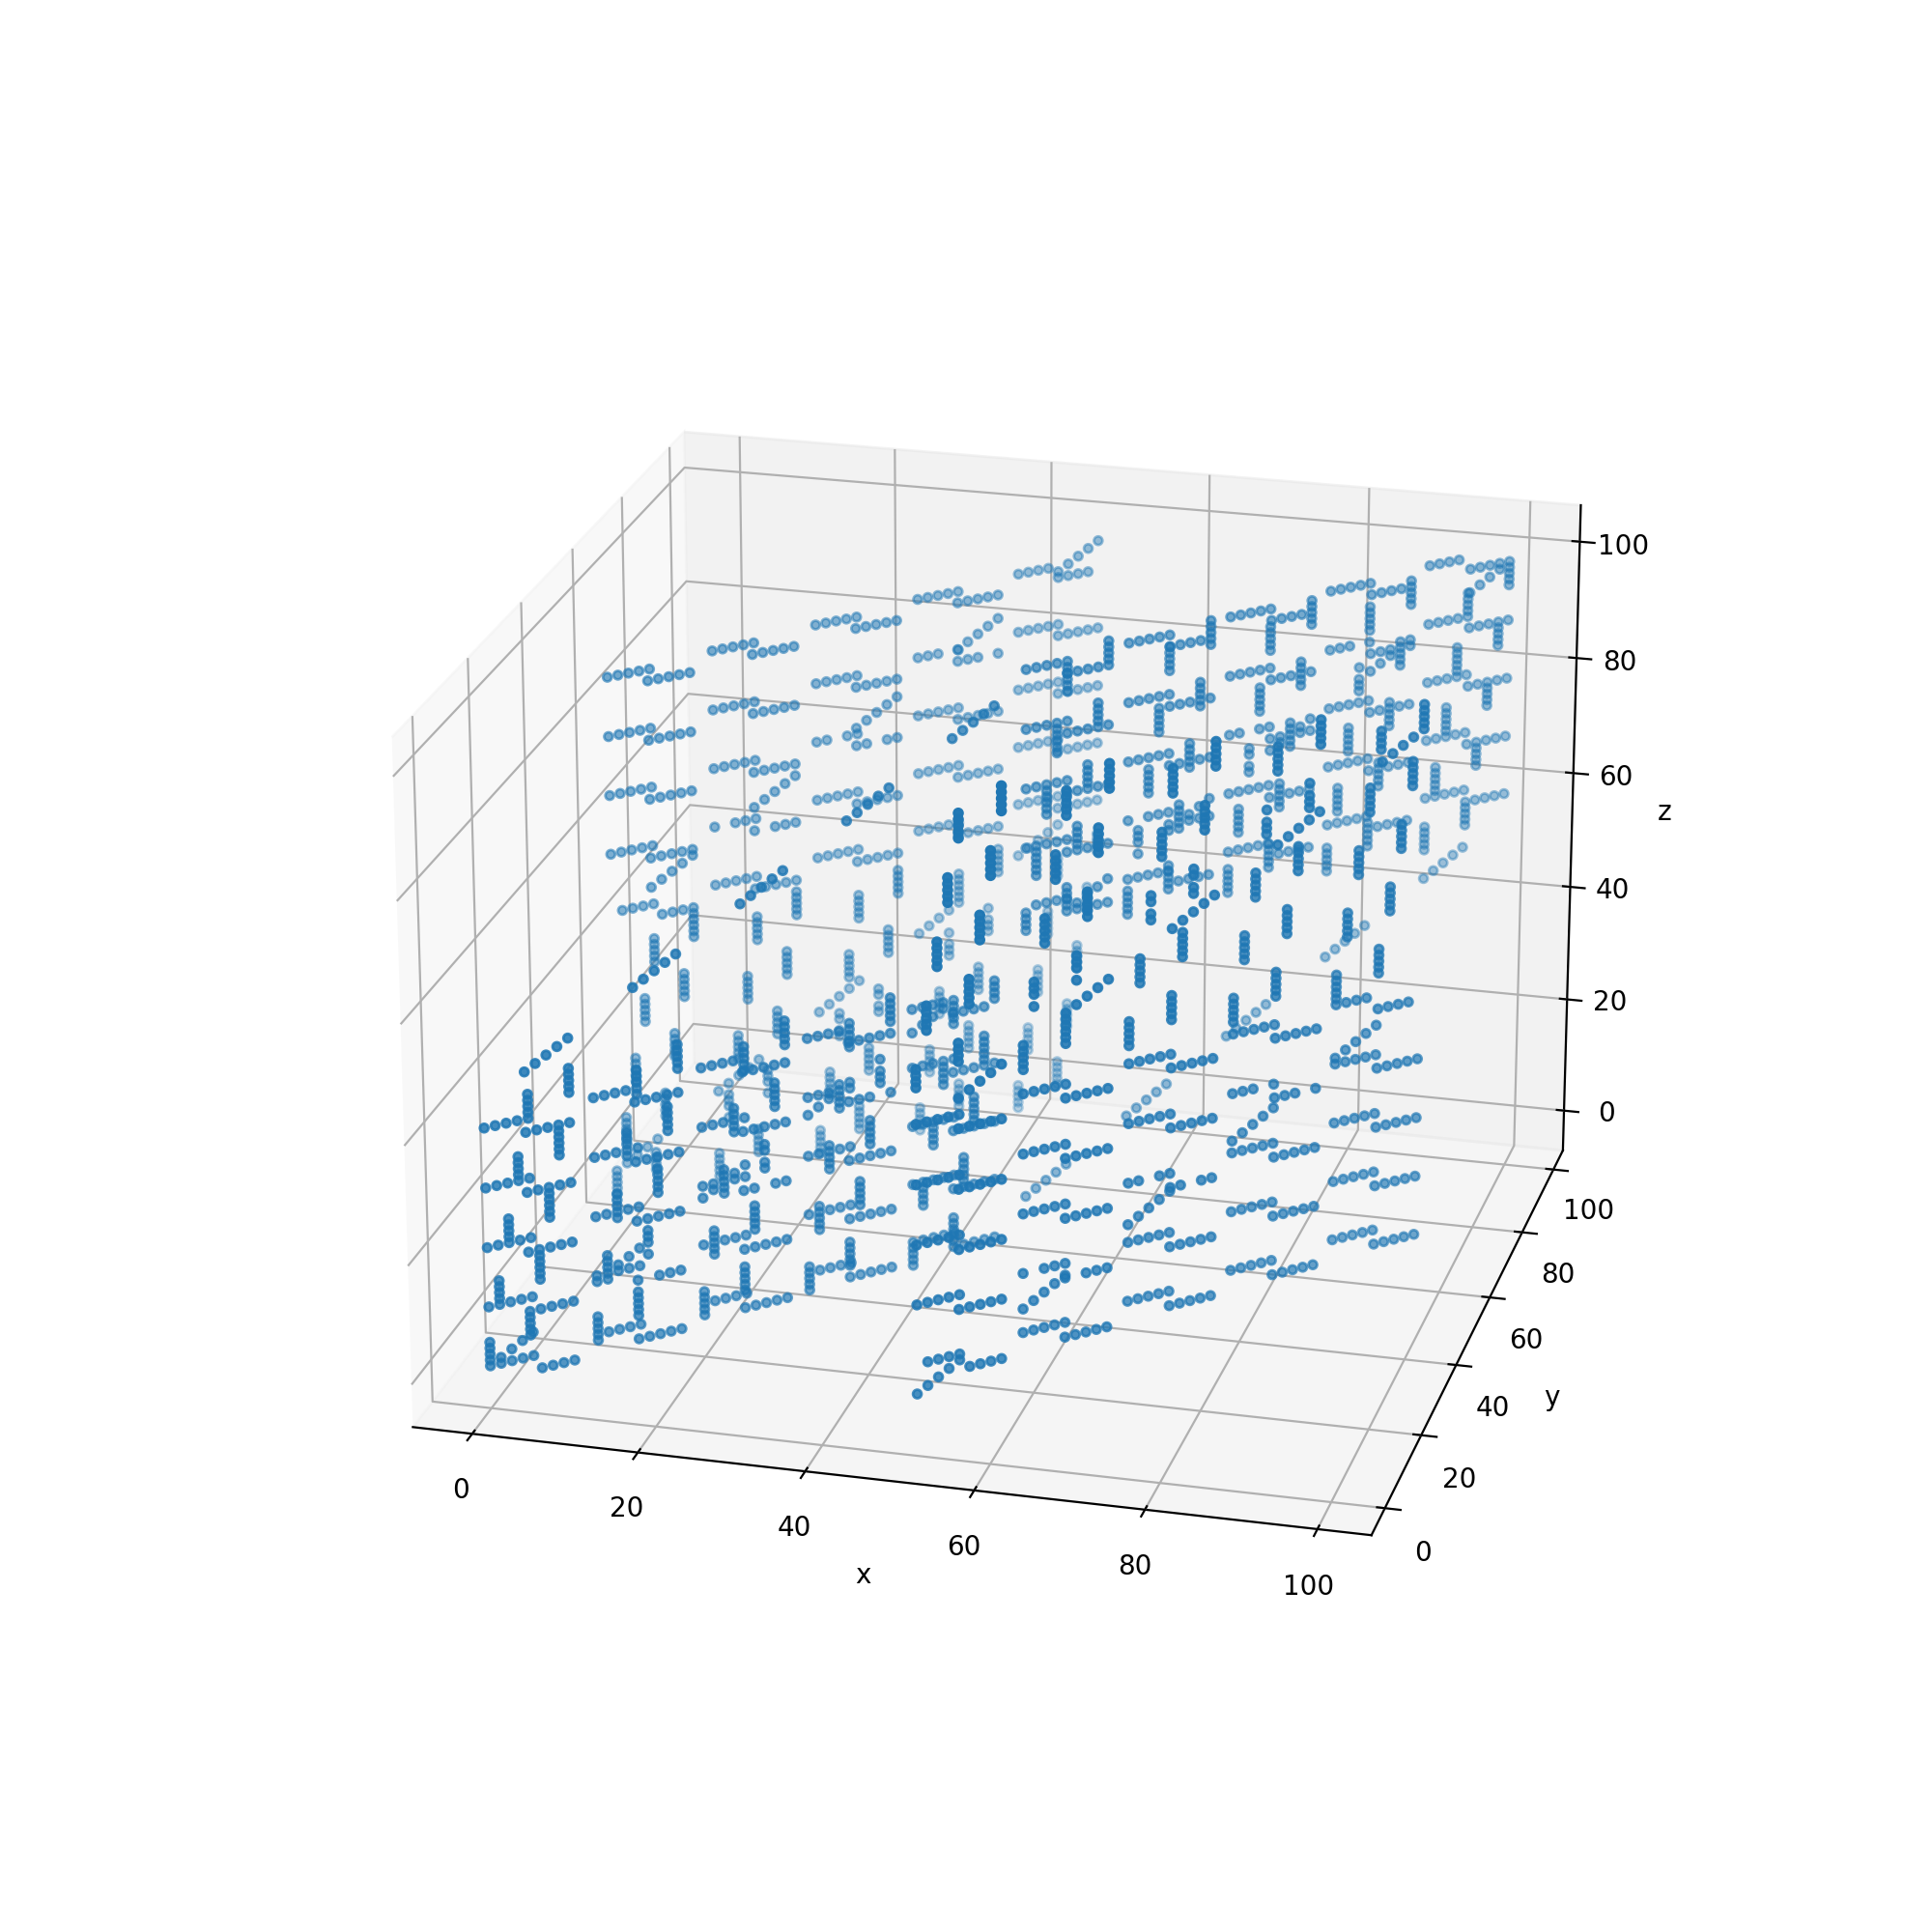

In [6]:
N=5
E=lambda i,j:np.array([[1 if r==i and c==j else 0 for c in range(2*N)] for r in range(2*N)])
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
S=set()
for i in range(N):
    for j in range(N):
        for k in range(N):
            if (i<j and i<k and j!=k) or (j==k and i!=j):
                S.add((i,j,k))
decomp=[(E(i+a*N,i+b*N),E(i+b*N,i+c*N),E(i+c*N,i+a*N)) for i in range(N) for a in range(2) for b in range(2) for c in range(2)]
for i,j,k in S:
    decomp.extend([
        (E(i,j)+E(j,k)+E(k,i),)*3,
        (-E(i,j)+E(j+N,k)+E(k,i+N),E(j,k+N)+E(k,i)+E(i+N,j),-E(k+N,i)+E(i,j+N)+E(j,k)),
        (E(i,j+N)-E(j,k)+E(k+N,i),E(j+N,k)+E(k,i+N)+E(i,j),E(k,i)-E(i+N,j)+E(j,k+N)),
        (E(i+N,j)+E(j,k+N)-E(k,i),E(j,k)+E(k+N,i)+E(i,j+N),E(k,i+N)+E(i,j)-E(j+N,k)),
        (E(i+N,j+N)+E(j+N,k+N)+E(k+N,i+N),)*3,
        (-E(i+N,j+N)+E(j,k+N)+E(k+N,i),E(j+N,k)+E(k+N,i+N)+E(i,j+N),-E(k,i+N)+E(i+N,j)+E(j+N,k+N)),
        (E(i+N,j)-E(j+N,k+N)+E(k,i+N),E(j,k+N)+E(k+N,i)+E(i+N,j+N),E(k+N,i+N)-E(i,j+N)+E(j+N,k)),
        (E(i,j+N)+E(j+N,k)-E(k+N,i+N),E(j+N,k+N)+E(k,i+N)+E(i+N,j),E(k+N,i)+E(i+N,j+N)-E(j,k+N)),
    ])
#TODO: FIND LOW-RANK DECOMP BY USING GRAPH GROUPING INTO MINIMAL # OF CONNECTED COMPONENTS
#plotT(ax,compress(sumdecomp(decomp)-mmT(2*N)),cmapname='bwr',alpha=0.5)
pts=np.array(np.where(compress(sumdecomp(decomp)-mmT(2*N))!=0)).transpose()
good_sigs=set(((0,0,0,0),(0,1,0,0),(1,0,0,1),(0,0,1,0),(1,1,1,1),(1,1,0,1),(0,1,1,0),(1,0,1,1)))
good_pairs=set()
for i in range(N):
    for j in range(N):
        for s in good_sigs:
            good_pairs.add(((i+s[0]*N)*(2*N)+(j+s[1]*N),(i+s[2]*N)*(2*N)+(j+s[3]*N)))
mask=np.array([True]*len(pts))
for a in range(3):
    m=np.array([(pt[a],pt[(a+1)%3]) in good_pairs for pt in pts])
    if a==0:
        ax.scatter(*pts[m].transpose(),s=10)
    mask|=m
assert np.sum(mask)==len(pts), 'not all points included'
#TODO: decompose sumdecomp(decomp)-mmT(2*N) with minimal rank (rank is O(N^2))
# def aggregate(C,I):
#     X=lambda s,t,r,c:C[s][t]*E(r+I[s][(s+t)%3]*N,c+I[s][(s+t+1)%3]*N)
#     return [(X(0,0,i,j)+X(1,0,j,k)+X(2,0,k,i),X(0,1,j,k)+X(1,1,k,i)+X(2,1,i,j),X(0,2,k,i)+X(1,2,i,j)+X(2,2,j,k)) for i,j,k in S]
# coeffss=[]
# for i in range(4):
#     tmp=np.ones((3,3))
#     if i>0:
#         tmp[i-1][0]=tmp[i-1][2]=-1
#     coeffss.append(tmp)
# sigs=[np.zeros((3,3)),[[0,0,1],[0,1,0],[1,0,0]],[[0,1,0],[1,0,0],[0,0,1]],[[1,0,0],[0,0,1],[0,1,0]]]
# tables=list(zip(coeffss,sigs))
# tables.extend(list(zip(coeffss,list(map(lambda x:1-np.array(x),sigs)))))
# print(tables)
# adecomp=[]
# for t in range(8):
#     adecomp.extend(aggregate(*tables[t]))
# print(np.array_equal(sumdecomp(decomp),sumdecomp(adecomp)))
#plotT(ax,compress(sumdecomp(adecomp)-mmT(2*N)),alpha=0.2)

<IPython.core.display.Javascript object>


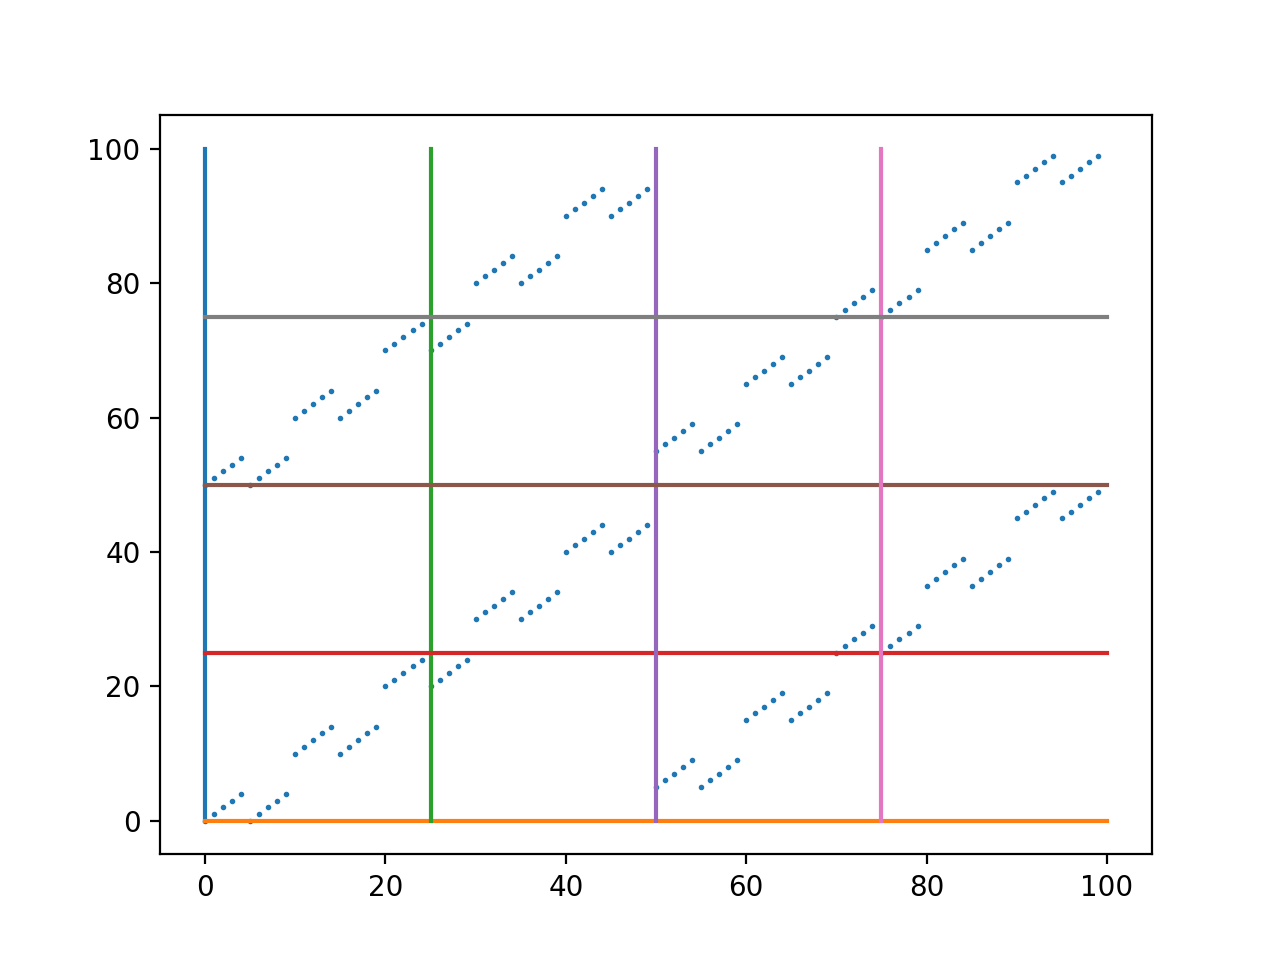

In [40]:
plt.figure()
good_sigs=set(((0,0,0,0),(0,0,1,0),(1,0,0,1),(0,1,0,0),(1,1,1,1),(1,1,0,1),(0,1,1,0),(1,0,1,1)))
pts=[]
for i in range(N):
    for j in range(N):
        for s in good_sigs:
            pts.append(((i+s[0]*N)*(2*N)+(j+s[1]*N),(i+s[2]*N)*(2*N)+(j+s[3]*N)))
plt.scatter(*np.array(pts).transpose(),s=1)
for i in range(4):
    plt.plot((i*N*N,)*2,(0,4*N*N))
    plt.plot((0,4*N*N),(i*N*N,)*2)